## Optimal Stop-Losses and Rebounds
By John Loeber

Notebook released under the Creative Commons Attribution 4.0 License.

---

### Abstract

We use a naive approach based on conditional probability to attempt to find optimal stop-losses for maximizing future profits. We conclude that naive stop-losses do not seem useful, since the profit-maximizing move for any loss from peak appears to be to wait for the rebound and then to sell. We also encounter several opportunities for further investigation.

### Definition

A stop-loss is a simple policy that some traders use to protect themselves from large losses. Suppose a trader buys some shares and decides that if the shares fall more than 5% from their peak (i.e. local maximum over the time period for which he has held the shares), he will sell them. That's a 5% stop loss. Of course the trader has to decide on how large to set the stop-loss: 3%? 9%? 15%? The trader would want to set a stop-loss large enough to allow for the usual noise and fluctuations of the market, but would also want the stop-loss to be small enough to pick up an indication of long-term price decline as early as possible.

Note that some investors define stop-losses as applying to losses from the raw investment, not from peaks. For example: suppose you buy a share at \$1, it rises to \$100, and then declines to \$90. That would trigger an 8% stop loss from peak, but not an 8% stop loss from investment. On the other hand, suppose you buy a share at \$1, and it falls to \$0.50. That would trigger both a stop loss from peak and a stop loss from investment. In this investigation, I use the **stop-loss from peak**, though you can tweak the parameters in this notebook to investigate stop-losses that are differently defined.


### Identifying the Problem

Underlying the principle of a stop-loss is a simple conditional probability question: if a share has dropped in price by $x\%$ from its peak, what is the probability that the share price will be at least $y\%$ above that point, within the next $d$ days? Computing the probability distribution for $y \in [-100, \infty)$ lets us calculate the expected value of our investment. Based on that expected value, we decide whether to sell. (Note: implicitly, we would also want to evaluate the expected values of alternative investments for that time period, and compare to the expectation of the current investment.)

Without loss of generality, we will let $d = 365$. If you prefer a different window, you will find it easy to adjust $d$ appropriately and to step through the investigation. 

Thus, what we're interested in is the distribution $P(Y=y\, | X=x)$, where $X$ is the loss from peak and $Y$ is the maximum percentage difference from the stop-loss point within $d=365$ days. We can use Quantopian's large-scale stock [price datasets](https://www.quantopian.com/help#overview-datasources) to approximate the distribution. However, applying all data from 2002-2015 is likely to yield results that are overly general, so we must first classify the price data using some heuristics/fundamentals that we think are likely to yield substantially different stop-losses.

### Classification and Conditioning

To achieve greater precision in identifying the optimal stop-loss, we will want to classify stocks according to particular variables. Then we can compute the optimal stop-loss for each class of stocks, assuming that due to their relative homogeneity, they should share an (approximately) optimal stop-loss.

In the interest of keeping the investigation manageably short, we will only look into one class of stocks. If you are curious about other classes, it'll be easy to change the variables appropriately.

In selecting the values for our variables, we cast our net reasonably broadly so as to prevent [overfitting](https://en.wikipedia.org/wiki/Overfitting).
1. Sector: Technology ([Morningstar ID](https://www.equitieslab.com/wiki/admin/morningstar-sector) 311)
2. Market Cap: \$1b-\$10b
3. Volatility over past 90 days: within the middle 75% (of the stocks filtered by 1,2)
4. Aggregate volume over past 90 days: within middle 75% (of the stocks filtered by 1,2)
5. Variance in volume over past 90 days: within the middle 75% (of the stocks filtered by 1,2)

We use the [Quantopian Fundamentals](https://www.quantopian.com/help#ide-fundamentals) to do this filtering. 

----

Note that if you were to run this investigation on another sector, different variables might be appropriate (e.g. price-earnings is inappropriate for tech, but may be appropriate for industrials).

Also note this approach is technically suboptimal. Ideally, we would consider a space of variables as large as possible and run principal component analysis in order to isolate maximally uncorrelated components for classification. Further, we should run the computations for all possible values of the classifying variables in attempt to tease out general patterns and perhaps a closed-form expression  (over these variables) for optimizing stop-losses. Both of these approaches have some significant complications to them, so we need to postpone them to a later investigation.

### Method

We split the period between April 2002 and July 2015 into 53 segments of 90 days each. For each segment, we find the set of stocks satisfying the five criteria above. For each stock, we then find its peak price in the last 90 days before the segment, and calculate by how much it has sunk $(x\%)$ at the start of the segment. Then we look at its price, $d=365$ days in the future from the start of the segment. We calculate the percent change $(y\%)$ from the start of the segment. We round $x$, and then place $y$ in a bucket with other $y$s for the same $x$.

Once we've gone through all 90 days, we compute the mean of each bucket, which is the expected value for that $x$. This results in a dataset that maps each $x$ to some expected $y$. We can then plot/analyze that dataset.

----

In an earlier draft of this investigation, I tried to approximate the probability distributions in the traditional statistical way, but I didn't have enough datapoints to draw on, hence the expected-value technique.

In [3]:
# import the libraries we will need
import datetime
import numpy
import math
import pandas

from matplotlib import pyplot
from scipy import stats, poly1d

# initialize fundamentals
fundamentals = init_fundamentals()

# set the look-ahead (d) and look-back (n) windows
d = 365
n = 90

In [4]:
# helper functions

def add_days(s,x):
    """ takes a date in string format and adds exactly n days to it"""
    end = datetime.datetime.strptime(s,'%Y-%m-%d') + datetime.timedelta(days=x)
    return end.strftime('%Y-%m-%d')

def get_volatility(opens,closes):
    """ calculates volatility as per 
        https://en.wikipedia.org/wiki/Volatility_(finance)#Mathematical_definition """
    # first: calculate the daily logarithmic rate of return
    daily_log_returns = [math.log(opens[x]/closes[x]) for x in range(len(opens))]
    sigma_period = numpy.std(daily_log_returns)
    volatility = sigma_period / math.sqrt(len(opens))
    return volatility

def get_loss(max_price,current_price):
    # how we define the peak is very important/controversial: 
    # I've decided to use the global max over a 90 day period.
    return ((max_price - current_price)/max_price)*100

def get_future_price(sid, today, future_date):
    """gets maximum price of an equity over the next 365 days."""
    p = get_pricing(sid, 
                    start_date = today,
                    end_date = future_date,
                    fields = 'close_price',
                    frequency = 'daily')
    m = max(p)
    if math.isnan(m):
        return 0
    else:
        return m

In [5]:
# starting in april because we want the 90-day window for looking back on volatility
start_date = '2002-04-03'

# map percent loss from peak to future price difference from "today". Use increments of 1%.
mapping = {}

# 13 * 365 = 4745 i.e. roughly the number of days up to the present
# 4745/90 = 52.9 periods of 90 days
for day in range(53):
    today = add_days(start_date, 90*day)
    stocks_initial = get_fundamentals(query()
                                 .filter(fundamentals.valuation.market_cap > 1e9)
                                 .filter(fundamentals.valuation.market_cap <= 1e10)
                                 .filter(fundamentals.asset_classification.morningstar_sector_code == 311)
                                 ,today)
    sids = [x.sid for x in stocks_initial]
    
    n_days_ago = add_days(today,-n)
    
    # list of tuples: (sid, volume_total, volume_variance, volatility, today_price, max_price)
    # where vt, vv, v, and mp are all over 90 days
    today_data = []
    
    for stock in sids:
        stock_data = get_pricing(stock, 
                                 start_date = n_days_ago, 
                                 end_date = today,
                                 fields = ['open_price', 'close_price','volume'],
                                 frequency = 'daily')
        today_price = stock_data.close_price[-1]
        
        # calculate metrics for filtering.
        volume_total = sum(stock_data.volume)
        volume_variance = numpy.var(stock_data.volume)
        start_price = stock_data.close_price[0]
        end_price = stock_data.close_price[-1]
        volatility = get_volatility(stock_data.open_price, stock_data.close_price)
        max_price = max(stock_data.close_price)
        data_tuple = (stock,volume_total,volume_variance,volatility,today_price, max_price)
        today_data.append(data_tuple)
   
    volatilities = [v for (s,vt,vv,v,tp,mp) in today_data]
    volumes = [vt for (s,vt,vv,v,tp,mp) in today_data]
    vvs = [vv for (s,vt,vv,v,tp,mp) in today_data]
    # get middle 50% for volatility
    volatility_25 = numpy.percentile(volatilities,12.5)
    volatility_75 = numpy.percentile(volatilities,87.5)
    # get middle 50% for aggregate volume
    volume_25 = numpy.percentile(volumes,12.5)
    volume_75 = numpy.percentile(volumes,87.5)
    # get middle 50% for volume variance
    vv_25 = numpy.percentile(vvs,12.5)
    vv_75 = numpy.percentile(vvs,87.5)

    # Note that we filter for middle 75% three times. If they were totally uncorrelated, we would expect
    # 100 * 0.75^3 = 42% of the dataset to remain. But we actually get a little bit more
    # (I tested this briefly), so we know the variables by which we are 
    # filtering have some internal correlation.
    
    filtered = filter(lambda (s,vt,vv,v,tp,mp): (volatility_25 <= v <= volatility_75) \
                        and (volume_25 <= vt <= volume_75) and (vv_25 <= vv <= vv_75), today_data)

    # now, for each of the remaining datapoints, find how far it is down from peak
    remaining_sids = [s for (s,vt,vv,v,tp,mp) in filtered]
    future_date = add_days(today,d)
    
    for data_point in filtered:
        percent_decrease_from_peak = get_loss(data_point[5],data_point[4])
        rounded_decrease = round(percent_decrease_from_peak)
        
        future_price = get_future_price(data_point[0],today,future_date)
        percent_increase_from_current = ((future_price - data_point[4])/data_point[4])*100
        
        if rounded_decrease in mapping:
            mapping[rounded_decrease] += [percent_increase_from_current]
        else:
            mapping[rounded_decrease] = [percent_increase_from_current]
    #print day

In [6]:
# mapping of percent decrease to expectation (mean) of future increase
ev_mapping = {}

for key in sorted(mapping.keys()):
    try:
        values = mapping[key]
        mu = numpy.mean(values)
        ev_mapping[key] = mu
        #print key, values, "\n"

    except:
        continue

### Clarification

At this point, we're at the end of the "method" described earlier. `ev_mapping` is the dataset that maps each $x$ to the expected $y$. It is worth reiterating that to get the expected $y$, we take the mean of all $y$s in that bucket, where a $y$ is the maximum percent increase in share price over the next 365 days. That means that the expected $y$ is **not** the percent increase we expect after $d$ days, it is the percent increase we expect **within** $d$ days -- we don't take into account the equity falling in price after reaching that peak. We now begin our analysis.

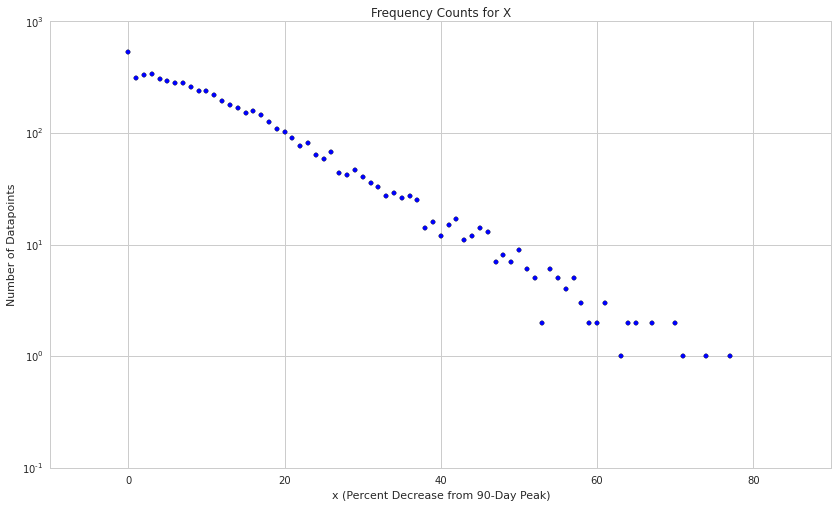

In [7]:
# First, we want to see what our data even looks like. 
# Below is a plot of how many datapoints we have for each x.
ks = sorted(mapping.keys())
vs = [len(mapping[k]) for k in ks]

pyplot.scatter(ks,vs,c='blue')
pyplot.xlabel("x (Percent Decrease from 90-Day Peak)")
pyplot.yscale('log')
pyplot.ylabel("Number of Datapoints")
pyplot.title("Frequency Counts for X")
pyplot.show()

Note that the y-axis is log-scaled. This allows us to make a few observations: for each $x \in [0,18]$, we have at least 100 datapoints -- sufficient for drawing conclusions. However, for each $x \geq 51$, we have 10 datapoints or fewer! For most $x \geq 60$, we only have one datapoint each. That doesn't allow for much statistical confidence at all. We keep this in mind as we move on.

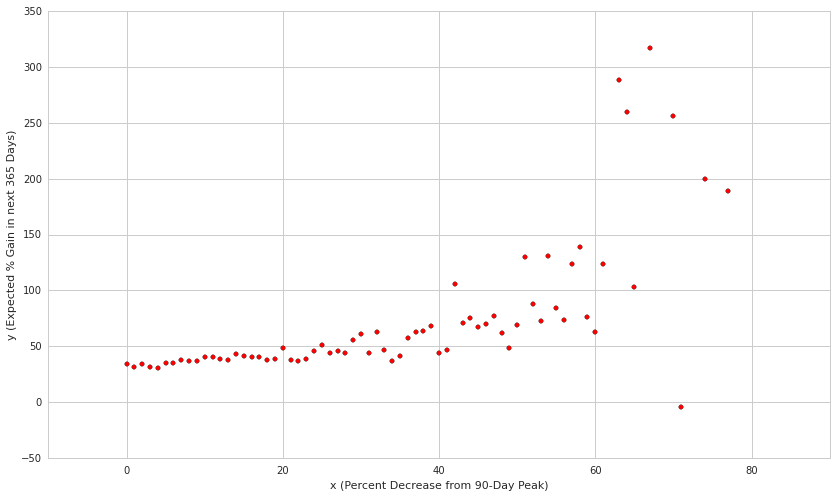

In [8]:
# plot x against y

keys = ev_mapping.keys()
values = [ev_mapping[k] for k in keys]

pyplot.scatter(keys,values,c='red')
pyplot.xlabel("x (Percent Decrease from 90-Day Peak)")
pyplot.ylabel("y (Expected % Gain in next 365 Days)")
pyplot.show()

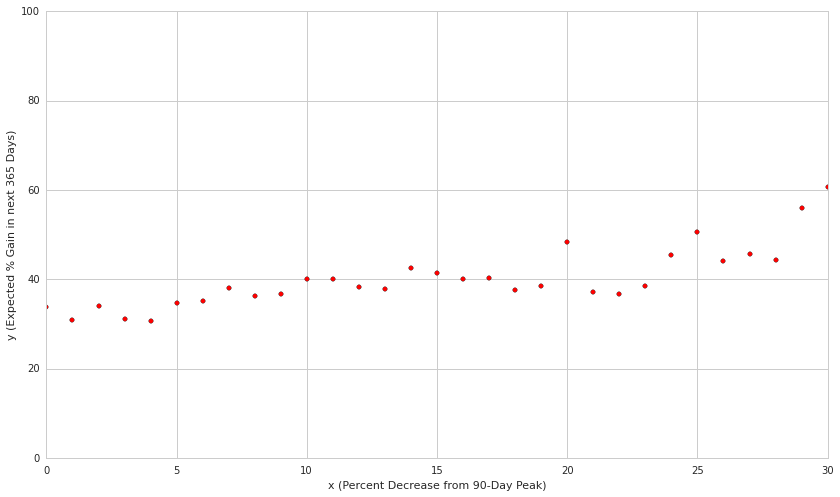

In [9]:
# let's zoom in on the above graph.

pyplot.scatter(keys,values,c='red')
pyplot.xlim(0,30)
pyplot.ylim(0,100)
pyplot.xlabel("x (Percent Decrease from 90-Day Peak)")
pyplot.ylabel("y (Expected % Gain in next 365 Days)")

pyplot.show()

What the two graphs above suggest is that at least for $ x \in [5,25]$, **the stoploss you pick doesn't really matter, since the expected % gain over the next 365 days is approximately the same for all those $\boldsymbol x$**. Especially considering the potential noise in the data (since we took it over a long timespan where macroeconomic confounding variables may be present), there's no clear optimum here.  We see some deviation from that trend for $x \in [0,4]$.

What's more interesting is the noisy but unmistakable upward trend in $y$ with $x$. We do know from our earlier frequency plot of datapoints that our samples for when $x$ is large are generally very small, which gives us low confidence in the accuracy of individual datapoints for large $x$, but the overall trend is quite clear (and, in aggregate, substantiated by a reasonably large number of datapoints).

But why should a stock that has already fallen by some 60% in the past 90 days be expected to rise back up by 100% in the next year? Note that when a stock falls by 60% from its peak and then rises back up by 100%, the stock ends with 80% of its peak value. Intuitively, this makes sense: stock prices don't follow smooth, monotonic functions, they trend up and down erratically. 

In that sense, it does not appear entirely unreasonable to say that a stock that has fallen 60% from its 90-day peak (i.e. to 40% of its peak) is likely to be worth 80% of its peak at some point in the next year. We are familiar with *mean reversion* from the trading literature, and considering that the peak is above, if not significantly above the moving average, the pattern of having a large $y$ for large $x$  can be justified. For lack of a better name, we'll call this *rebounding*.

Thus, to test rebounding, we adjust the above plots slightly: instead of calculating the percent change from the stoploss point (i.e. the point in time at which we measure x), we calculate the percent change between [the peak in the 90 days before the stoploss point] and [the peak in the 365 days after the stoploss point].

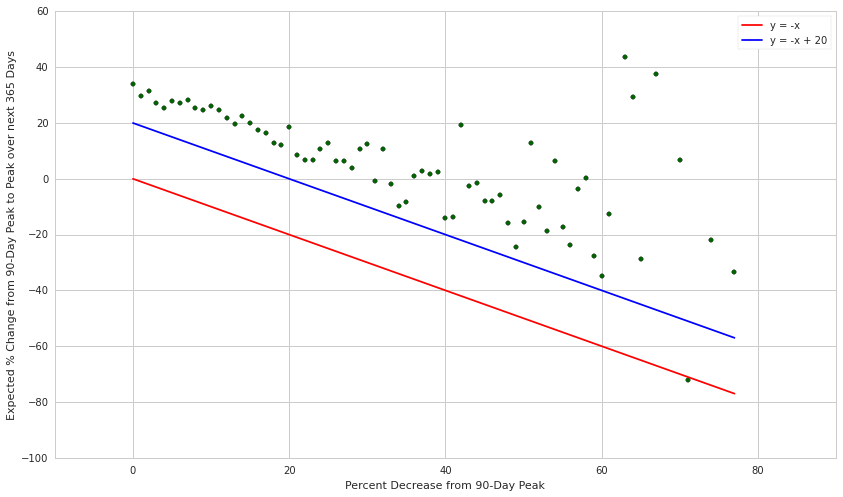

In [10]:
def adjust(x,y):
    # indexed the peak, easier to handle
    index = 1.0
    res = ((100-x)/100.0) * ((100+y)/100.0)
    pct_change = ((res-index)/index) * 100
    #print x, y, pct_change
    return pct_change

new_ys = [0 for k in keys]

for i in range(len(keys)):
    new_ys[i] = adjust(keys[i],values[i])
    
pyplot.scatter(keys,new_ys,c='darkgreen')
line = map(lambda x: -x, keys)
#lin = numpy.polyfit(keys, new_ys, 1)
#pyplot.plot(keys, poly1d(lin)(keys))
pyplot.plot(keys,line, c='red', label = 'y = -x')
pyplot.plot(keys,map(lambda x: x + 20, line), c='blue', label = 'y = -x + 20')
pyplot.legend()
pyplot.xlabel("Percent Decrease from 90-Day Peak")
pyplot.ylabel("Expected % Change from 90-Day Peak to Peak over next 365 Days")
pyplot.show()

What we see in the plot above is commensurate with our intuition. A percent decrease from the 90-day peak that is close to zero implies that a stock is "upwards trending," and it is not unthinkable that the stock price over the next year will, at least on some spike, substantially exceed the previous 90-day peak. As we look at larger $x$, it becomes progressively harder for a stock to climb back up to its previous peak, though there is always some rebound to that effect.

That comes out of the following observation: consider the red line, which is $y = -x$. If a stock were on this line, it would mean that the percent decrease from the 90-day peak to the measurement day would be the same as the percent decrease from the 90-day peak to the 365-day peak, which would mean that the stock price both on the measurement day and on the 365-day peak would be the same (i.e. for all other 364 days would be equal or even lower). 

The blue line is given by $y = -x + 20$. Since all datapoints but one (which I checked -- it's just one stock) are above the line, it implies that a stock can be expected to, over the course of a year, at least at some point be priced at 

$$ (\text{90-Day Peak Price}) \cdot \frac{120 - (\text{Percent Decrease from 90-Day Peak Price})}{100}$$

----

Note that we have not put any confidence intervals or measures of error on any of the data discussed. This will be critical to do before going much further.

It is subject to future investigation whether the expected rebound gives rise to a feasible trading signal on any time-span (i.e. different from the 90/365 day periods we've been using).

It is also subject to future investigation whether the large % rebounds that we saw on the zoomed-out red-dotted graph give rise to a feasible trading signal on any time-span. For example, whether it is a viable strategy to purchase diverse aggregates of stocks that have fallen between 40% and 60% in the past 90 days, and then to sell after some expected rebound.

### Further Questions and Caveats

An immediate question is whether the above-observed patterns hold for other/analogous sets of variables. I ran this experiment on data from the Industrial Sector (Morningstar Sector Code 310), which yielded very similar results, differing only in more right-tail dispersion in expected $y$, and on the green-dotted graph, five datapoints on the right $x$-tail were slightly below the blue line.

Another important question is to what extent the above-observed patterns hold for other time periods, i.e. to what extent they depend on macroeconomic circumstances. We used data from 2002 through 2015: a serious caveat to this investigation is the variety in macroeconomic circumstances (2010-2015 has been a strong bull market, whereas 2007-2009 was the recession, etc.) that we lumped into one. Ideally, we want to narrow our focus on particularly macroeconomically distinguished periods and identify how those affected stop-losses. We'll save that for a following investigation.

A final caveat is that of the five variables that we used as a screening criterion for stocks, one of them was implicitly not constant: we discounted inflation from the \$1bn-\$10bn window. This is a notable difference, since \$1 in 2000 is equal to $1.395 in 2015 when adjusted for inflation. 

### Concluding Remarks

On average over the last thirteen years, if at a given point we observe a price decrease from a peak (over the last 90 days) by between 5 and 25%, then in expectation we predict that the stock in question will peak at a 40% increase in the next 365 days (from that given point). The predicted increase is approximately the same for all $x \in [5,25]$. 

The percent-loss-from-90-day-peak measurement, predicts, for practically all $x \in [0,70]$, a peak in price over the next 365 days that is at least 20% higher than the price at the given point. In expectation, that beats the risk-free rate of returns in any case.

Thus, in this investigation, we have not found any percent loss from a 90-day peak that is predictive of future market movements to the extent of being a reliable sell-signal. **In other words, there is no percent loss from a 90-day peak for which selling the asset at that point is necessarily a profit-maximizing move. The data suggests that at any given loss from peak, it's best to just wait it out to the expected rebound/price spike and then to sell.** We note that this is riskier for large $x$ because the relationship between $x$ and $y$ for large $x$ has not been accurately determined due to small sample sizes. 

We remark that it is well possible that if given more conditioning variables or other heuristics, it might be possible to use the conditional probability model to tease out some stop-losses that appear to work better than others. This analysis might be fruitful for very short-term windows, as at that point using a stop-loss is in some sense a momentum-based trading technique. We are yet to investigate stop-losses for small windows.

Finally, we note, as an investigation for another time, the question of to what extent using a stop loss is effective in the first place. The results of this investigation suggest that naive stop-losses, based on little more than share price, are not useful.

### Adapting this Notebook

You can use this notebook to run experiments similar to the ones I ran above. The crux of the notebook is the look-ahead and look-back windows, over each of which we find a peak. In this experiment, we looked back 90 days, and we looked ahead 365 days. Both of these parameters are set in the very start as `d` and `n`. 

The only other parameters you may want to change are the fundamentals that we query in the third cell of code. If you are unfamiliar with using the fundamentals, there is a tutorial notebook on fundamentals in the "Tutorials and Documentation" folder in your research environment.